# Organización de Datos (9558)

## Trabajo Práctico N° 2

#### Fecha: 2017-06-22

#### Integrantes:


#### Repo:
[Github - TP2](https://github.com/frisjon/tp2)

---
*tabla de contenidos*

---
#### Enunciado

El segundo TP es una competencia de Machine Learning en donde cada grupo debe intentar predecir la duración de los viajes en base a los datos de los mismos. La competencia se desarrolla en la plataforma de Kaggle, se provee un archivo "train.csv" que debe ser usado para entrenar un modelo de Machine Learning y un archivo "test.csv" que tiene los datos de los viajes a predecir. Adicionalmente pueden usarse los datos de las estaciones, del status de cada estación minuto a minuto y la información meteorológica.

ADVERTENCIA MUY IMPORTANTE: Dado que los datos son públicos los resultados de la competencia ya se saben, son parte de los datos del TP1, es fundamental que ningún grupo suba a Kaggle submissions que usan esta información ya que distorsiona el score de la competencia y una vez subido un submission es IMPOSIBLE ELIMINARLO. Los submissions
deben generarse en base a un modelo de machine learning y nunca en base a los resultados que ya se conocen.

TL;DR: NO SUBIR A KAGGLE SUBMISSIONS QUE HACEN TRAMPA, ES IMPOSIBLE BORRARLOS!!!

Los grupos deberán probar distintos algoritmos de Machine Learning para predecir la duración de los viajes en base a los datos de los mismos. A medida que los grupos realicen pruebas deben realizar el correspondiente submit en Kaggle para evaluar el resultado de los mismos. Al finalizar la competencia el grupo que mejor resultado tenga obtendrá 10 puntos para cada uno de sus integrantes que podrán ser usados en el examen por promoción o segundo recuperatorio.

Requisitos para la entrega del TP2:
1. El TP debe programarse en Python o R
- Debe entregarse una carpeta con el informe de algoritmos probados, algoritmo final utilizado, transformaciones realizadas a los datos, feature engineering, etc.
- El grupo debe presentar el TP en una computadora en la fecha indicada por la cátedra, el TP debe correr en un lapso de tiempo razonable (inferior a 1 hora) y generar un submission válido que iguale el mejor resultado obtenido por el grupo en Kaggle.

El TP2 se va a evaluar en función del siguiente criterio:
1. Cantidad de trabajo (esfuerzo) del grupo: ¿Probaron muchos algoritmos? ¿Hicieron un buen trabajo de pre-procesamiento de los datos y feature engineering?
- Resultado obtenido en Kaggle (obviamente cuanto mejor resultado mejor nota)
- Presentación final del informe, calidad de la redacción, uso de información obtenida en el TP1, conclusiones presentadas.
- Performance de la solución final.


ADVERTENCIA IMPORTANTE #2: Bajo ningún concepto debe interpretarse que es necesario finalizar el TP1 para poder comenzar el TP2, quienes incurran en este error se encontrarán que el tiempo necesario para desarrollar el TP2 es insuficiente. Es fundamental, imprescindible y vital comenzar el desarrollo del TP2 en forma paralela al TP1 para evitar problemas en el cumpimiento de las fechas de entrega.

---
#### [Descipción](https://inclass.kaggle.com/c/san-francisco-biking)

El propósito de esta competencia es predecir la duración de los viajes.

El objetivo de esta competencia es predecir la duración de los viajes de acuerdo a los datos de los mismos, la información meteorológica, etc.

Pueden usarse los siguientes archivos disponibles en:

https://www.kaggle.com/benhamner/sf-bay-area-bike-share

    .status
    .station 
    .weather

Para los viajes debe usarse el archivo train.csv provisto par entrenar el modelo y el archivo test.csv tiene los datos de los viajes a predecir.

IMPORTANTE: El archivo trips.csv del TP anterior tiene los resultados que queremos predecir, estos resultados NO DEBEN usarse de ninguna forma para el entrenamiento del modelo. No subir a Kaggle ningún submission que sea generado a partir de estos datos ya que afecta la evaluación de la competencia y NO ES POSIBLE ELIMINAR SUBMISSIONS. 

---
#### [Evaluación y Formato de Entrega](https://inclass.kaggle.com/c/san-francisco-biking/details/evaluation)

La evaluación es por Mean Squared Error es decir la diferencia de cuadrados entre la duración real del viaje y la duración que se predice mediante el modelo de Machine Learning usado.

El formato de submission es un archivo .csv de la forma:

    id,duration
    1,1
    8,8
    9,9 10
    10,10 9
    etc.

---
#### Conclusiones del TP 1

> Los usuarios del serivicio, en su mayoria, lo utiliza para trasladarse al trabajo.

> Ya conocemos cuáles son los datos a filtrar.

> ... (agregar mas)

---
#### Algunos comentarios sobre cosas en general (eliminar al terminar el tp)

Entender como se resuelve. Utilizamos perceptrones, etc?

Analizar los datos y determinar qué features son importantes.

Armar el modelo. (Cómo juntar los features)

Probar lo de cross validation, etc

---
Antes de seguir leyendo, podemos averiguar sobre cómo otras personas encaran este tipo de proyectos. Tal vez las preguntas se consteten de esa manera. 

[kernels de kaggle](https://www.kaggle.com/benhamner/sf-bay-area-bike-share/kernels)

[papers](https://drive.google.com/drive/u/0/folders/0B8rBD4QSqWnSRDRFUkVDSnVMMFk)

---
#### Introduciendo a la API

[Tensorflow](https://www.tensorflow.org/get_started/get_started)

>(En el link, hay explicaciones de las estructuras utilizadas en tensorflow.) -mk

>(Asumiendo que utilizamos tensorflow, podemos armar un modelo basico.) -mk

>##### Ejemplo de una parte del modelo

>Un dato entra, separamos las partes (o dimensiones) que consideramos importantes, realizamos cálculos con ellos y devolvemos un resultado.

>Una parte del algoritmo (un *nodo* en tensorflow), podría tomar como parámetros a las id's de las estaciones y devolver la distancia entre ellas. Luego la distancia, irá por otras partes del modelo que serán utilizadas para determinar el resultado final que es la duración del viaje.

>(Acá van las consideraciones de la api, (que estructuras de datos estan disponibles, como se pueden utilizar y como las VAMOS a utilizar). Despues en __plan__, ya juntamos todas las consideraciones y formamos el plan) -mk

[SciKit-Learn](http://scikit-learn.org/stable/index.html)

>Tiene muchas cosas implementadas.

---
#### Sets de Datos y Feature Engineering

En esta sección analizamos los datos a modo de preparación de armado del modelo.

Los sets de datos son:

>[Entrenamiento y testeo](https://inclass.kaggle.com/c/san-francisco-biking/data) ( https://inclass.kaggle.com/c/san-francisco-biking/data )

>[Set de datos del TP1](https://www.kaggle.com/benhamner/sf-bay-area-bike-share) ( https://www.kaggle.com/benhamner/sf-bay-area-bike-share )

In [1]:
import time
start = time.time()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Leemos los datos del set de entrenamiento
train = pd.read_csv('./data/train.csv', low_memory=False)

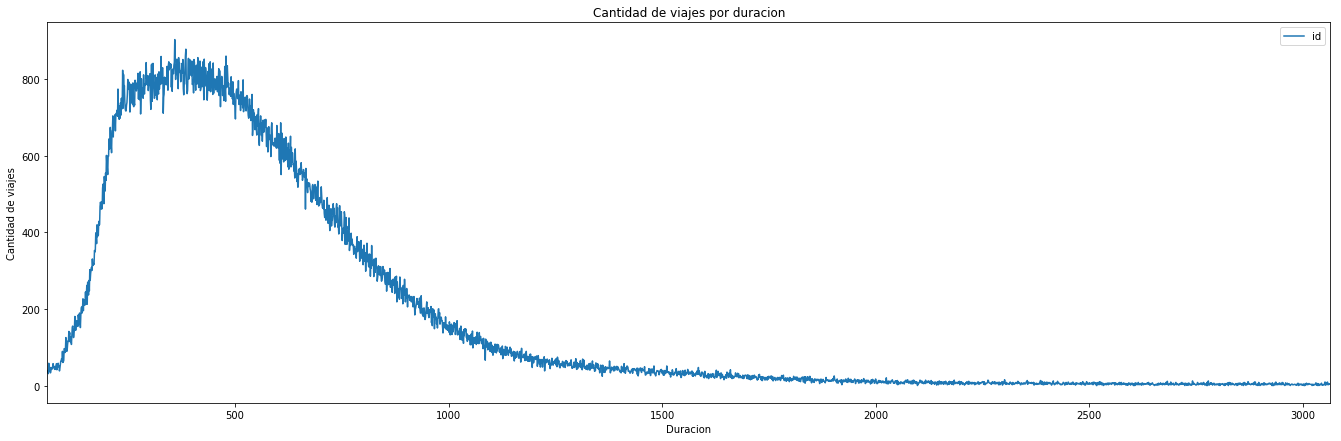

In [4]:
train[['id', 'duration']].groupby('duration').count().head(3000).plot(figsize=(23, 7));
plt.title('Cantidad de viajes por duracion');
plt.xlabel('Duracion');
plt.ylabel('Cantidad de viajes');

Del gráfico se observa que hay una gran cantidad de viajes de duración entre 200 y 600 segundos. (__Atención__: En el gráfico se muestran 3.000 de 14.614 duraciones diferentes)

---
##### Datos a filtrar

Para manejar y visualizar los datos, utilizamos *pandas*.

In [5]:
train = pd.read_csv('./data/train.csv', low_memory=False)

In [6]:
train.sample(3)

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
378971,869532,656,7/30/2015 17:39,2nd at South Park,64,7/30/2015 17:50,Market at Sansome,77,363,Subscriber,94610
243932,621865,196,1/28/2015 9:49,Civic Center BART (7th at Market),72,1/28/2015 9:53,Market at 10th,67,222,Subscriber,94112
100298,279405,942,5/10/2014 20:02,Embarcadero at Sansome,60,5/10/2014 20:17,Powell at Post (Union Square),71,284,Customer,10600


Unas primeras observaciones son:

> Los nombres de las estaciones no son necesarios ya que se conocen sus identificaciones.
>
> El tipo de suscripción se puede convertir a un número. Además sólo hay dos tipos de suscripción.
>
> Las identificaciones de los viajes tampoco son necesarias ya que no aportan informacion útil.
>
> (Zip-code, creo se puede sacar)

In [7]:
# Cambiamos los nombres de los features, para que sea mas fácil de leer
nombres = {'subscription_type':  'sub_type',
           'start_station_name': 'ss_name',
           'end_station_name':   'es_name',
           'start_station_id':   'ss_id',
           'end_station_id':     'es_id',
           'start_date':         's_date',
           'end_date':           'e_date',
           'zip_code':           'z_code',
           'bike_id':            'b_id'}

train.rename(columns=nombres, inplace=True)

In [8]:
# Convertimos el formato de fecha
# El parametro 'format' hace que se ejecute un poco mas rápido
train.s_date = pd.to_datetime(train.s_date, format='%m/%d/%Y %H:%M')
train.e_date = pd.to_datetime(train.e_date, format='%m/%d/%Y %H:%M')

# Creamos una columna 'date' para poder hacer un merge con los datos del clima
train['date'] = pd.DatetimeIndex(train.s_date).normalize()

In [9]:
# Agregamos el dia de la semana
# 0: Lunes
# 1: Martes
# 2: Miercoles
# 3: Jueves
# 4: Viernes
# 5: Sabado
# 6: Domingo

train['s_day'] = train['s_date'].map(lambda x: x.weekday())
train['e_day'] = train['e_date'].map(lambda x: x.weekday())

In [10]:
# Convertimos las fechas a unix time
# En este paso convertimos a unix time, despues de pasarlo a formato datetime. creo que asi es mas rapido. probar
train.s_date = pd.DatetimeIndex(train.s_date).astype(np.int64) // 10**9
train.e_date = pd.DatetimeIndex(train.e_date).astype(np.int64) // 10**9

In [11]:
# Quitamos las columnas que no son necesarias
train.drop(['ss_name', 'es_name', 'z_code', 'id'], axis=1, inplace=True)

In [12]:
# Funcion para convertir el tipo de subscripcion
def sub_type(sub):
    if sub == 'Customer': return 1
    return 0

In [13]:
# Convertimos el tipo de subscripcion a valores numericos
train.sub_type = train.sub_type.map(sub_type)

In [14]:
# Vemos como queda el set de entrenamiento
train.sample(3)

,duration,s_date,ss_id,e_date,es_id,b_id,sub_type,date,s_day,e_day
277241,196,1391765280,61,1391765460,70,412,0,2014-02-07,4,4
493580,386,1410253140,70,1410253560,62,465,0,2014-09-09,1,1
100520,246,1421050440,65,1421050680,70,421,0,2015-01-12,0,0


#### Añadiendo información del clima y estaciones

En esta sección agregamos información respecto al clima y distancias entre estaciones.

##### Clima

In [15]:
# Leemos el set de weather
weather = pd.read_csv('./data/weather.csv')

In [16]:
nombres = {'mean_sea_level_pressure_inches': 'mean_press',
           'max_sea_level_pressure_inches': 'max_press',           
           'min_sea_level_pressure_inches': 'min_press',
           'precipitation_inches': 'precipitation',
           'mean_visibility_miles': 'mean_vis',
           'max_visibility_miles': 'max_vis',           
           'min_visibility_miles': 'min_vis',
           'mean_temperature_f': 'mean_temp_f',
           'max_temperature_f': 'max_temp_f',           
           'min_temperature_f': 'min_temp_f',           
           'mean_wind_speed_mph': 'mean_wind',
           'max_wind_Speed_mph': 'max_wind',           
           'max_gust_speed_mph': 'max_gust',
           'mean_dew_point_f': 'mean_dew_f',
           'max_dew_point_f': 'max_dew_f',           
           'min_dew_point_f': 'min_dew_f',
           'wind_dir_degrees': 'wind_dir',
           'mean_humidity': 'mean_hum',
           'max_humidity': 'max_hum',           
           'min_humidity': 'min_hum',
           'zip_code': 'z_code',
           'events': 'event'}

weather.rename(columns=nombres, inplace=True)
weather.date = pd.to_datetime(weather.date, format='%m/%d/%Y')

In [17]:
# Quitamos los features que no consideramos importantes
drop = ['max_temp_f', 'min_temp_f', 'max_dew_f', 'min_dew_f', 'max_hum', 'min_hum', 'max_press', 'min_press', 'max_vis', 'min_vis', 'max_wind', 'max_gust', 'z_code']
weather.drop(drop, axis=1, inplace=True)

In [18]:
# Funcion para clasificar estaciones climaticas.
def estacion(date):
    if date.month >= 3 and date.month <= 5:    return 1
    elif date.month >= 6 and date.month <= 8:  return 2
    elif date.month >= 9 and date.month <= 11: return 3
    else:                                      return 4

In [19]:
# Determinamos la estacion del año
# 1: Primavera
# 2: Verano
# 3: Otoño
# 4: Invierno

weather['season'] = weather['date'].map(estacion)

In [20]:
# Funcion para convertir eventos
def events(event):
    eventos = ['fog', 'rain', 'fog-rain', 'rain-thunderstorm', 'nan']
    for i in range(len(eventos)):
        if event.lower() == eventos[i]: return i

In [21]:
# Convertimos los eventos del dia a valores numericos
# 0: Fog
# 1: Rain
# 2: Fog-Rain
# 3: Rain-Thunderstorm
# 4: No Event

weather['event'] = weather['event'].fillna("nan")
weather['event'] = weather['event'].map(events)

In [22]:
# Convertimos las precipitaciones
weather['precipitation'] = weather['precipitation'].map(lambda x: 0.0 if x == 'T' else float(x))

In [23]:
# Juntamos los datos de train y weather
datos = pd.merge(train, weather, how='right', on='date')

In [24]:
# Quitamos la columna 'date' que fue necesaria solamente para juntar con 'weather'
datos.drop('date', axis=1, inplace=True)

In [25]:
datos.sample(3)

,duration,s_date,ss_id,e_date,es_id,b_id,sub_type,s_day,e_day,mean_temp_f,mean_dew_f,mean_hum,mean_press,mean_vis,mean_wind,precipitation,cloud_cover,event,wind_dir,season
441953,981,1401786240,72,1401787260,60,454,0,1,1,60.0,49.0,68.0,29.92,10.0,11.0,0.0,4.0,4,278.0,2
1742304,957,1421081520,41,1421082480,70,464,0,0,0,55.0,50.0,86.0,30.22,9.0,3.0,0.0,1.0,4,357.0,4
534045,439,1403168280,61,1403168700,49,527,0,3,3,66.0,53.0,70.0,29.99,10.0,9.0,0.0,0.0,4,356.0,2


##### Distancias

In [26]:
stations = pd.read_csv('./data/station.csv', low_memory=False)
stations.drop(['name','installation_date'], axis=1, inplace=True)

In [27]:
# Funcion para calcular distancia euclidea sobre la proyecicon de coordenadas geograficas en un plano
from math import cos,sqrt,pi
def dist(a, b):
    ''' https://en.wikipedia.org/wiki/Geographical_distance#Spherical_Earth_projected_to_a_plane '''
    p = pi / 180
    x = (a[0] * p, a[1] * p)
    y = (b[0] * p, b[1] * p)
    f_m = (x[0] + y[0]) / 2
    d_lat = x[0] - y[0]
    d_lon = x[1] - y[1]
    return sqrt((d_lat)**2 + (cos(f_m) * d_lon)**2)*1000

In [28]:
# Creamos un dataframe de distancias
distancias = pd.DataFrame(columns=('ss_id','es_id','dist'))

for i in stations.values:
    for j in stations.values:
        distancias = distancias.append(pd.DataFrame({'ss_id':[i[0]],
                                                     'es_id':[j[0]],
                                                     'dist':[dist((i[1],i[2]),(j[1],j[2]))]}))

In [29]:
# Juntamos las distancias y los viajes
datos = datos.merge(distancias, how='left', on=['ss_id','es_id'])

In [30]:
datos['ss_id'] = datos['ss_id'].values.astype(np.int64)
datos['es_id'] = datos['es_id'].values.astype(np.int64)
datos.shape

(2749805, 21)

In [31]:
datos.dropna(inplace=True)
datos.shape

(2704934, 21)

In [32]:
datos.sample(3)

,duration,s_date,ss_id,e_date,es_id,b_id,sub_type,s_day,e_day,mean_temp_f,...,mean_hum,mean_press,mean_vis,mean_wind,precipitation,cloud_cover,event,wind_dir,season,dist
2060678,410,1400346840,4,1400347200,12,210,0,5,5,60.0,...,72.0,30.01,10.0,8.0,0.0,3.0,4,263.0,1,0.154186
357978,238,1436174100,71,1436174340,46,598,0,0,0,68.0,...,74.0,30.05,10.0,7.0,0.0,5.0,4,270.0,2,0.132236
2619116,521,1389789780,54,1389790320,48,585,0,2,2,58.0,...,44.0,30.28,10.0,1.0,0.0,0.0,4,320.0,4,0.266338


#### Por ahora vemos los datos reducidos porque son demasiados

In [33]:
datos.shape

(2704934, 21)

In [34]:
# Selecionamos 10.000 elementos al azar. Solo para hacer visualizaciones rapidas
df = datos.sample(10000).dropna(thresh=2)

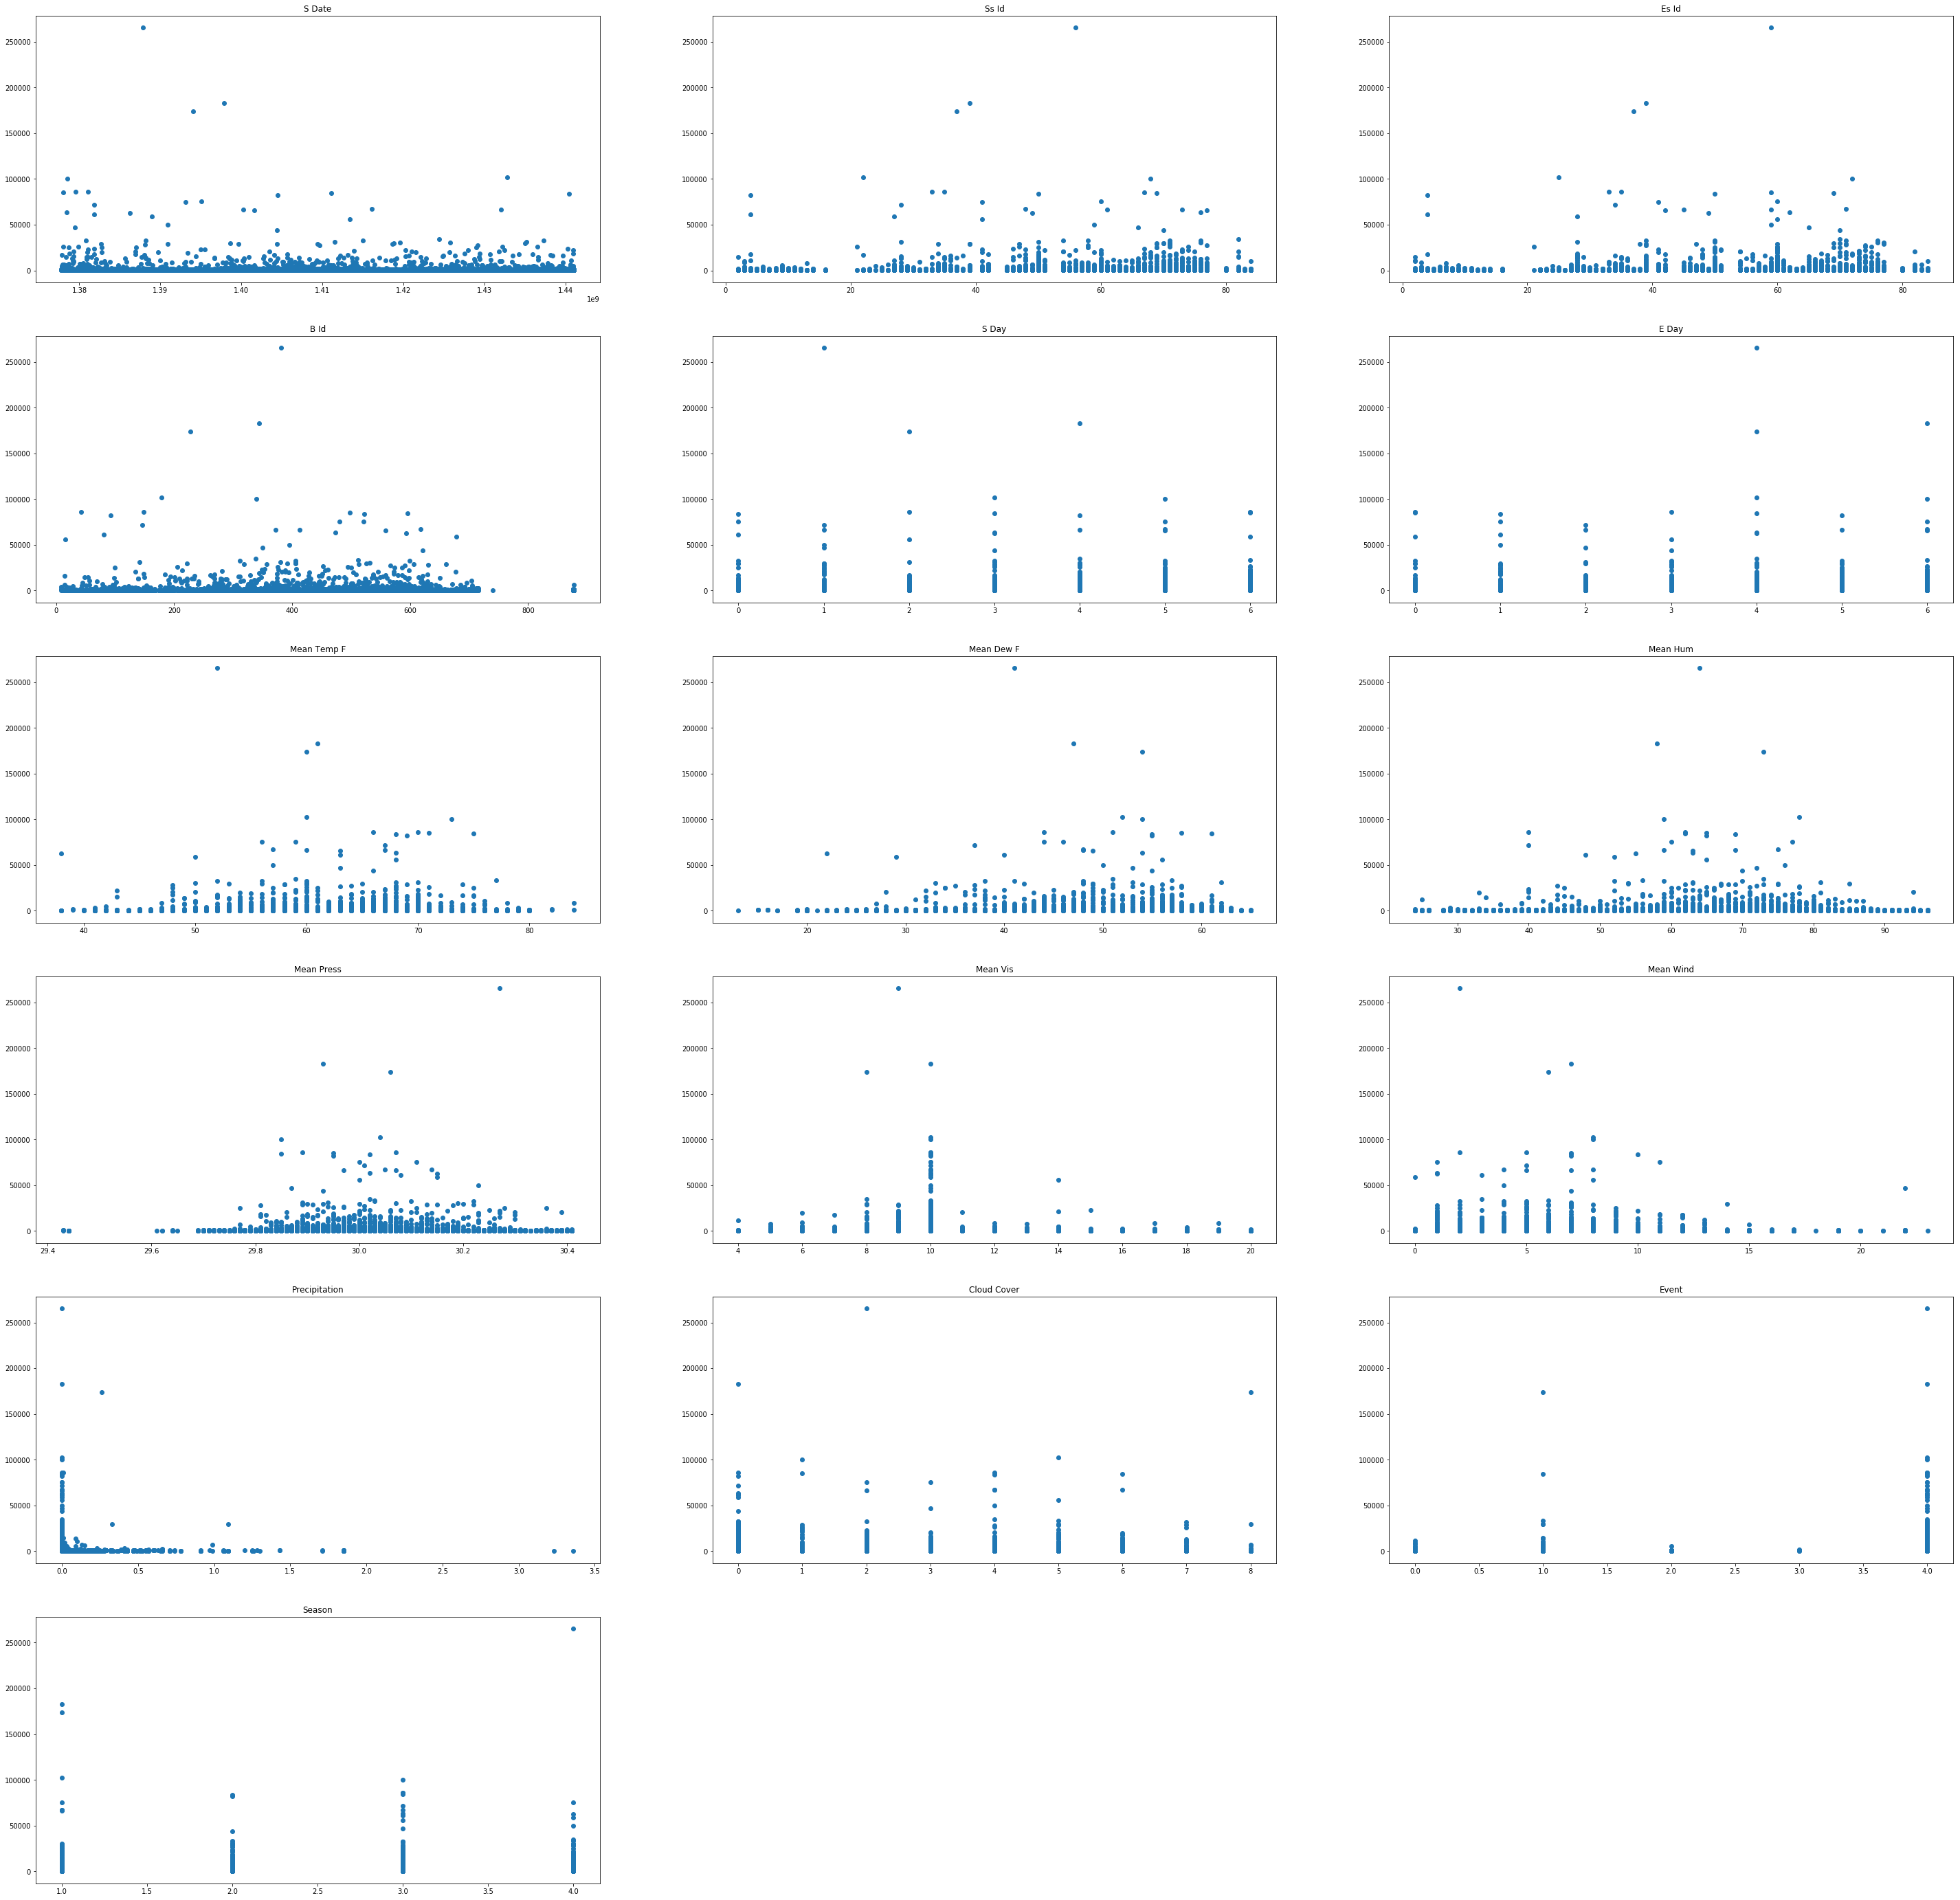

In [35]:
# Realizamos algunos plots
plots = ['s_date', 'ss_id', 'es_id', 'b_id', 's_day', 'e_day', 'mean_temp_f', 'mean_dew_f', 'mean_hum', 'mean_press', 'mean_vis', 'mean_wind', 'precipitation', 'cloud_cover', 'event', 'season', 'dist']
fig = plt.figure(figsize=(50, 50))

for i in range(len(plots)-1):
    ax = fig.add_subplot(6, 3, i+1)
    plt.title(plots[i].replace('_', ' ').title());
    ax.scatter(df[plots[i]], df['duration']);
plt.show()

In [36]:
#df.groupby('es_id').count()

Con más datos incluidos, podemos hacer una reducción de dimensiones y visualizar el set de datos

In [37]:
#PCA con sk-learn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(df.values)

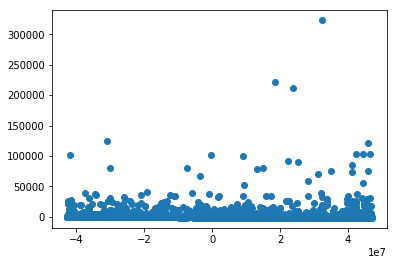

In [38]:
plt.scatter(X[:, 0], X[:, 1]);

(__Achtung!__, el método PCA no se aplicó a la matriz de distancia entre datos, sino sobre los datos en sí. Habría que probar realizar la matriz de distancia entre datos y luego aplicar PCA. (Primero habria que determinar una metrica o probar con todas))

Aplicamos SVD a los datos

In [39]:
from sklearn.decomposition import TruncatedSVD

In [40]:
df_train = train.drop('date', axis=1)

In [41]:
svd = TruncatedSVD(n_components=2, n_iter=7)
X = svd.fit_transform(df.values)
Y = svd.fit_transform(df_train.values)

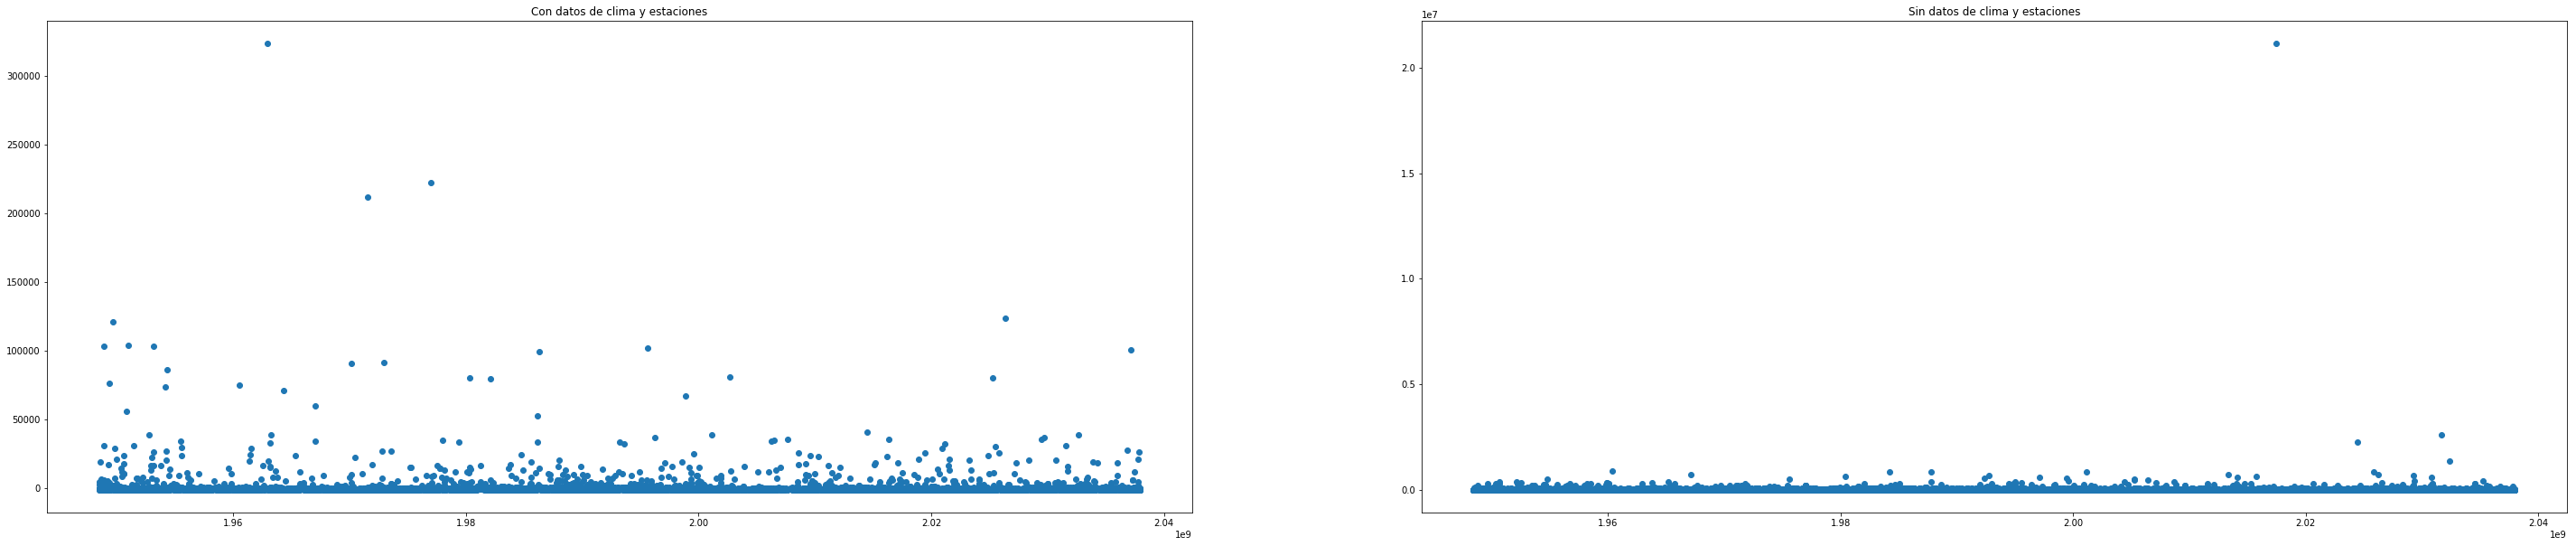

In [42]:
fig = plt.figure(figsize=(50, 10));
ax = fig.add_subplot(1, 2, 1);
plt.title('Con datos de clima y estaciones')
ax.scatter(X[:, 0], X[:, 1]);

ax = fig.add_subplot(1, 2, 2);
plt.title('Sin datos de clima y estaciones')
ax.scatter(Y[:, 0], Y[:, 1]);
plt.show()

Se puede observar una especie de relación lineal.

(Pero a mi me parece muy raro. Igualmente, la aproximacion de la SVD a 2 dimensiones reduce lo mejor posible los datos originales (a 2 dimensiones, por el teorema de Eckert-Young). Por lo tanto, esta es la mejor representacion en 2D de los datos (segun la *norma de Frobenius*)) [p.315 apunte]

---
#### Modelo

Finalmente, luego de realizar las consideraciones, en esta sección armamos el modelo que resuelva el problema de predicción.

*plan*

---
#### Ejecución del modelo

*Pruebas*

In [43]:
# Primero hay que separar el set de datos en set de entrenamiento y set de validacion
sets = []
num_sets = 10

for i in range(num_sets):
    sets.append(df[i*df.shape[0]/num_sets:(i+1)*df.shape[0]/num_sets-1])

linear model de sklearn (copy-paste)

In [44]:
data = datos
num = int(data.shape[0]*.2)

Coefficients: [ 589.18417579]
Mean squared error: 2294168596.47
Variance score: -0.00


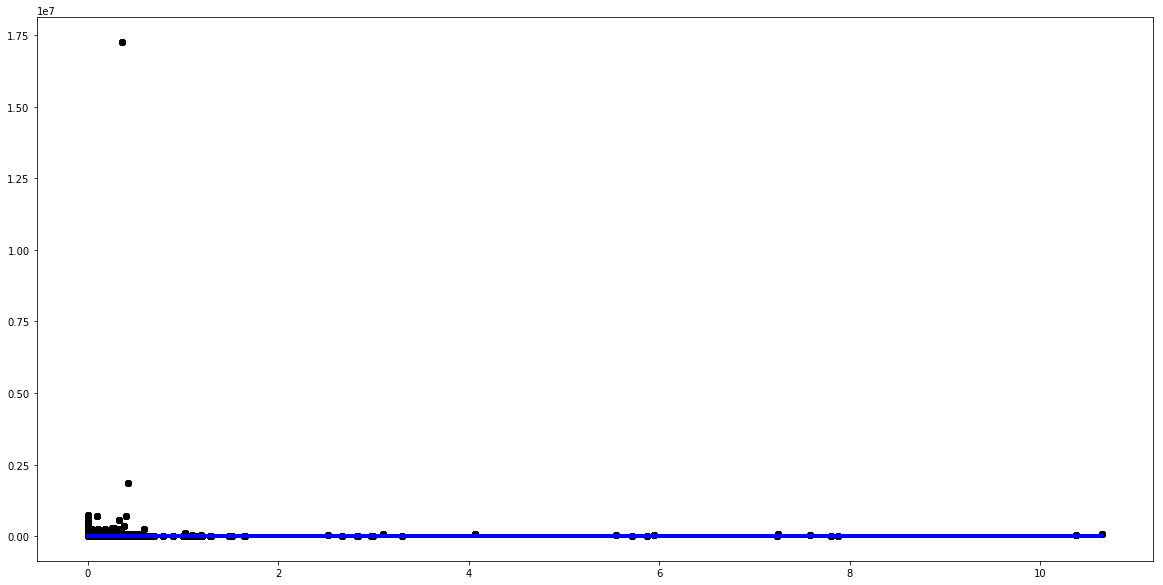

In [45]:
from sklearn import linear_model

x = data.dist.values
x = x.reshape(-1, 1)
y = data.duration.values

x_train = x[:-num]
x_test = x[-num:]

y_train = y[:-num]
y_test = y[-num:]

regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

print 'Coefficients:', regr.coef_
print "Mean squared error: %.2f" % np.mean((regr.predict(x_test) - y_test) ** 2)
print 'Variance score: %.2f' % regr.score(x_test, y_test)

plt.figure(figsize=(20, 10))

plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, regr.predict(x_test), color='blue', linewidth=3)

plt.show()

Segun los comentarios en el ejemplo de sklearn, si *Variance score* es 1, la prediccion es perfecta. Acá es 0 :C

In [46]:
end = time.time()
print end-start

57.9614050388
